In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as st
import seaborn as sns

In [360]:
df = pd.read_excel("DataSet.xlsx")
gps = df.loc[:,['Restaurant', 'Latitude', 'Longitude']]
gps.head(5)

,Restaurant,Latitude,Longitude
0,ID_6321,39.262605,-85.837372
1,ID_2882,39.775933,-85.740581
2,ID_1595,39.253436,-85.123779
3,ID_5929,39.029841,-85.332050
4,ID_6123,39.882284,-85.517407


Here we've made a subtable with only the restaraunt ID, Latitude, and Longitude. This is useful so we can cluster the restaurants in some way such that we can optimize the different "zones" that FoodieX drivers operate in. First, let's take a look at a simple scatter plot of this data:

Text(0.5, 0, 'Longitude')

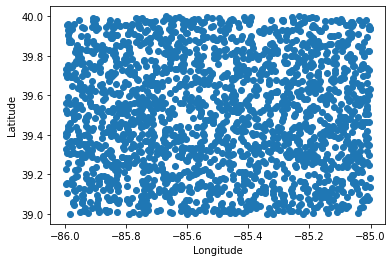

In [361]:
plt.scatter(gps.Longitude, gps.Latitude)
plt.ylabel('Latitude')
plt.xlabel('Longitude')


This isn't super enlightening, we can see that certain zones are more densely populated than others, but no clear patterns are emerging from a simple scatter plot. Now let's try a 2d histogram "heat map" of the data, first with 10 buckets for simplicity. 

[]

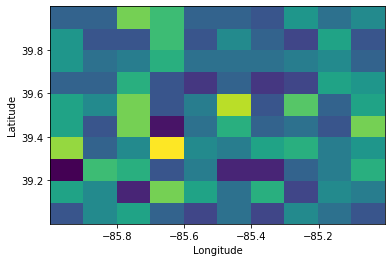

In [362]:
plt.hist2d(gps.Longitude, gps.Latitude, bins = 10)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot()

This looks a little better and we can see some spots where the restaurants are clustered together, but we can acquire a more detailed picture with different bucket sizes. Let's try 25, 50, 75, and 100. 

[]

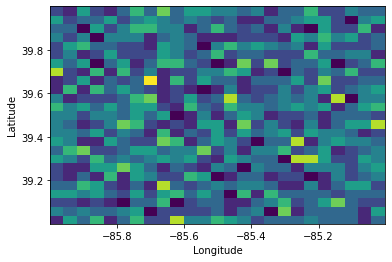

In [363]:
plt.hist2d(gps.Longitude, gps.Latitude, bins = 25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot()


[]

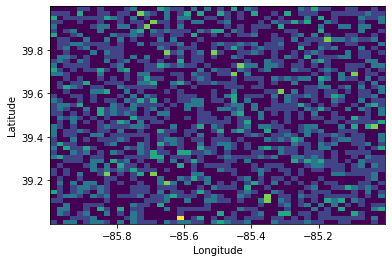

In [364]:
plt.hist2d(gps.Longitude, gps.Latitude, bins = 50)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot()

[]

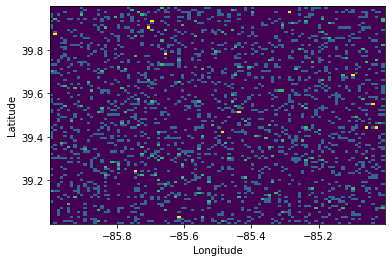

In [365]:
plt.hist2d(gps.Longitude, gps.Latitude, bins = 100)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.plot()

Unforutnately, these are not particularly helpful. The location of the yellow pips changes drastically based on the number of bins we choose, so we don't get a picture of the data that is very clear or cohesive. This illustrates very well one of my biggest gripes with any analysis based on drawing arbitrary lines separating "bins", as where we choose to draw these lines heavily impacts our final result, the same data can completely change shape depending on how one chooses to manipulate the dividing lines we draw. To avoid this, let's try a [kernel density function](https://scikit-learn.org/stable/modules/density.html) that avoids the drawing of bins entirely.

In [366]:
kernel = st.gaussian_kde(np.vstack((gps.Longitude, gps.Latitude)))
xx,yy = np.mgrid[gps.Longitude.min():gps.Longitude.max():50j,
                 gps.Latitude.min():gps.Latitude.max():50j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kernel(positions).T, xx.shape)




This sets up our contour map, which we will look at through a range of contour levels to give a cohesive picture. 

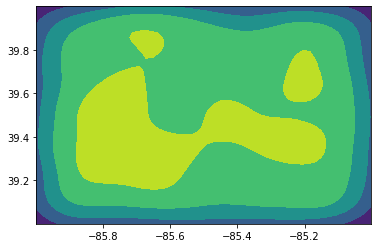

In [367]:
graph = plt.contourf(xx, yy, f,5)

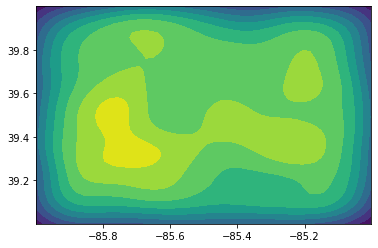

In [368]:
graph = plt.contourf(xx, yy, f,10)

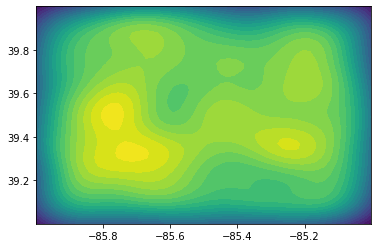

In [369]:
graph = plt.contourf(xx, yy, f,25)

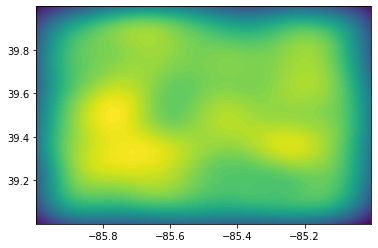

In [370]:
graph = plt.contourf(xx, yy, f,100)

This gives a clearer picture, where the overall shape is more or less preserved, with the higher contour levels just making the plot a little fuzzier. The n=10 map looks to be the most helpful, it preseves the shape in great detail while the yellow region shows the most densely restauranted area. To isolate this area, let's restric the value of f to be greater than 1.1, leaving us with:

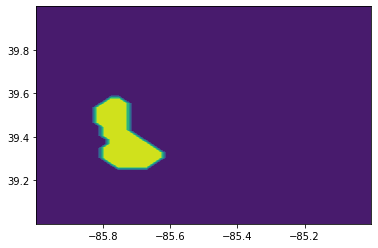

In [371]:
plt.contourf(xx, yy, f>1.1)

In [372]:
hotzone = df[kernel(np.vstack((gps.Longitude, gps.Latitude)))>1.1]
len(hotzone)

90

This leaves us with 90 restaurants. I claim these restaurants are in the "hotzone" for FoodieX, where the greatest overlap in location leaves us with the most opportunity to increase the efficiency of deliveries by grouping these deliveries together. While this does give us insight as to how best optimize our delivery routes for location, we still don't have any information on the relative popularity of the restaurants - if these 90 restaurants have fewer orders than 3 restaurants on the same block, this data might be misleading. Therefore, let's expand the requirements to take popularity into account.

We have three data points that can speak to popularity - votes, reviews, and rating. Votes is pretty self explanatory, but reviews/rating is a little trickier. The number of ratings is seemingly a reasonable estimator for the number of customers, but this assumes that all customers are equally likely to review a restaurant. I would argue that the most likely customers to leave reviews are customers who had very good or very bad experiences, leading to a bias in favor of the restaurants rated near either extreme. The restaurants rated near the middle of the pack, on the other hand, might have a smaller customer-to-reviewer ratio since no one is clamoring to post about an experience that was simply mediocre. We don't have any real data to go off of for this assumption unfortunately, as we don't have this mythical customer to reviewer ratio. 

Moreover, both of these statistics are confounded with the idea of quality, which is important to reviewers but not directly correlated with the sheer number of orders - McDonalds may not have as many stars as St. Elmo's but I'd wager they have many more customers. To get a better picture of this data, let's take a look at the correlation between votes, number of ratings, and average rating. We will only consider the restaurants which have data in these columns.

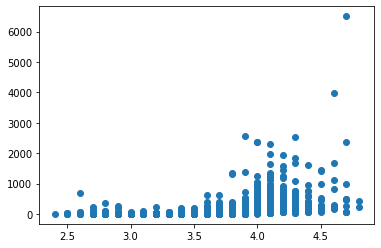

In [373]:
rating = df[df['Votes'].astype(str).str.isnumeric()]
rating = rating[rating['Reviews'].astype(str).str.isnumeric()]

plt.scatter(rating.Rating, rating.Reviews)

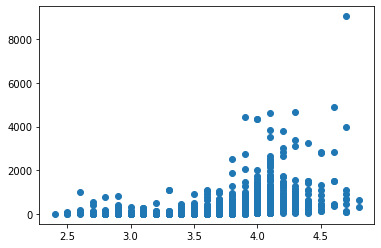

In [374]:
plt.scatter(rating.Rating, rating.Votes)

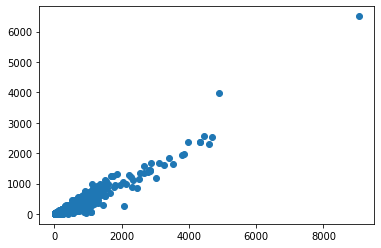

In [375]:
plt.scatter(rating.Votes, rating.Reviews)

We can see that the number of votes and reviews are heavily correlated, while both also share a weaker positive correlation with rating, lending some credence to our assumption that people are more likely to review restaurants they have strong feelings about. We're still doing a lot of guesswork here, but it makes sense to me to base our "popularity" metric on primarily ratings and reviews. Since this falls short for examples like fast food where a restaurant might be extremely popular but not held in high regard or particularly frequently reviewed, we will slightly punish higher-performing restaurants to try and account for the biases in the system. The formula to calculate rating will be:

(number of votes + number of reviews)(10-rating)

In [376]:
rating['Popularity'] = (rating.Votes + rating.Reviews)*(10-rating.Rating)
rating.head()

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,Popularity
0,ID_6321,39.262605,-85.837372,"Fast Food, Rolls, Burger, Salad, Wraps",20,50,3.5,12,4,30 minutes,104
1,ID_2882,39.775933,-85.740581,"Ice Cream, Desserts",10,50,3.5,11,4,30 minutes,97.5
2,ID_1595,39.253436,-85.123779,"Italian, Street Food, Fast Food",15,50,3.6,99,30,65 minutes,825.6
3,ID_5929,39.029841,-85.332050,"Mughlai, North Indian, Chinese",25,99,3.7,176,95,30 minutes,1707.3
4,ID_6123,39.882284,-85.517407,"Cafe, Beverages",20,99,3.2,521,235,65 minutes,5140.8


Now we have applied this metric for popularity to every restaurant we have data for. To get a better picture of how price and genre affect popularity, let's take a look at the simple correlations between cuisine type, average cost, and popularity.

([<matplotlib.axis.XTick at 0x7fb8c14addc0>,
 [Text(0, 0, 'American'),
  Text(1, 0, 'Italian'),
  Text(2, 0, 'Continental'),
  Text(3, 0, 'Asian'),
  Text(4, 0, 'Salad'),
  Text(5, 0, 'Cafe'),
  Text(6, 0, 'Burger'),
  Text(7, 0, 'Thai'),
  Text(8, 0, 'Kebab'),
  Text(9, 0, 'Seafood'),
  Text(10, 0, 'Momos'),
  Text(11, 0, 'Juices'),
  Text(12, 0, 'Mughlai'),
  Text(13, 0, 'Bakery'),
  Text(14, 0, 'Pizza'),
  Text(15, 0, 'Wraps'),
  Text(16, 0, 'Desserts'),
  Text(17, 0, 'Sandwich'),
  Text(18, 0, 'Chinese'),
  Text(19, 0, 'Healthy Food'),
  Text(20, 0, 'Street Food'),
  Text(21, 0, 'Beverages'),
  Text(22, 0, 'North Indian'),
  Text(23, 0, 'Lebanese'),
  Text(24, 0, 'South Indian'),
  Text(25, 0, 'Fast Food'),
  Text(26, 0, 'Mithai'),
  Text(27, 0, 'Biryani'),
  Text(28, 0, 'Ice Cream'),
  Text(29, 0, 'Rolls'),
  Text(30, 0, 'Maharashtrian'),
  Text(31, 0, 'Bengali')])

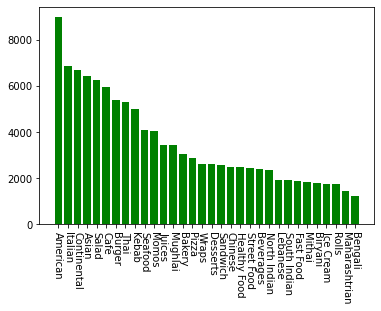

In [377]:
rating = rating[rating['Average_Cost'].astype(str).str.isnumeric()]
rating = rating[rating['Minimum_Order'].astype(str).str.isnumeric()]


df.Cuisines.str.split(',')
cuisines = {}
for ix, row in df.iterrows():
    for x in [y.strip() for y in row.Cuisines.split(',')]:
        cnt = cuisines.get(x,0)
        cuisines[x] = cnt+1

#sorted([(x,y) for y,x in cuisines.items()], reverse = True)

def getCuisineIX(cuisine):
    return rating.Cuisines.str.contains(cuisine)

def cuisineCount(cuisine):
    return getCuisineIX(cuisine).sum()

def cuisineMean(cuisine):
    return rating[getCuisineIX(cuisine)].Popularity.mean()
    
    
    
toPlot = []

for cuisine in cuisines.keys():
    if cuisineCount(cuisine) > 15 :
        toPlot.append(cuisine)
        
means = []

for cuisine in toPlot:
    means.append((cuisineMean(cuisine), cuisine))

means = sorted(means, reverse = True)

means, toPlot = [[i for (i,j) in means],
                 [j for (i,j) in means]]

    
x_pos = [i for i, _ in enumerate(means)]

plt.bar(x_pos, means, color='green')
plt.xticks(x_pos, toPlot, rotation = 270)

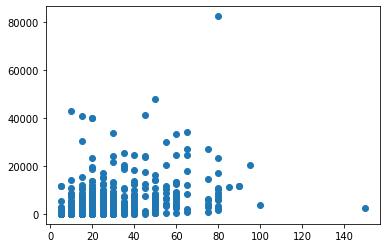

In [378]:
plt.scatter(rating.Average_Cost, rating.Popularity)

([<matplotlib.axis.XTick at 0x7fb8f108ee20>,
 [Text(0, 0, 'Asian'),
  Text(1, 0, 'Thai'),
  Text(2, 0, 'Kebab'),
  Text(3, 0, 'Continental'),
  Text(4, 0, 'American'),
  Text(5, 0, 'Italian'),
  Text(6, 0, 'Salad'),
  Text(7, 0, 'Seafood'),
  Text(8, 0, 'Mughlai'),
  Text(9, 0, 'Cafe'),
  Text(10, 0, 'Pizza'),
  Text(11, 0, 'Chinese'),
  Text(12, 0, 'North Indian'),
  Text(13, 0, 'Healthy Food'),
  Text(14, 0, 'Wraps'),
  Text(15, 0, 'Burger'),
  Text(16, 0, 'Biryani'),
  Text(17, 0, 'Momos'),
  Text(18, 0, 'Beverages'),
  Text(19, 0, 'Sandwich'),
  Text(20, 0, 'Desserts'),
  Text(21, 0, 'Lebanese'),
  Text(22, 0, 'Maharashtrian'),
  Text(23, 0, 'Rolls'),
  Text(24, 0, 'Bakery'),
  Text(25, 0, 'Fast Food'),
  Text(26, 0, 'Bengali'),
  Text(27, 0, 'South Indian'),
  Text(28, 0, 'Ice Cream'),
  Text(29, 0, 'Street Food'),
  Text(30, 0, 'Mithai'),
  Text(31, 0, 'Juices')])

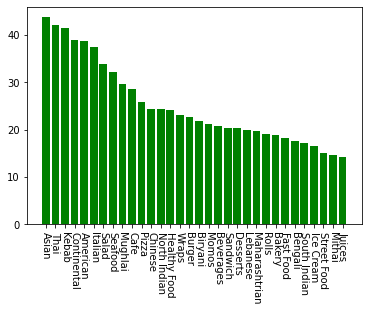

In [379]:
def cuisineMeanPrice(cuisine):
    return rating[getCuisineIX(cuisine)].Average_Cost.mean()
means = []

for cuisine in toPlot:
    means.append((cuisineMeanPrice(cuisine), cuisine))

means = sorted(means, reverse = True)

means, toPlot = [[i for (i,j) in means],
                 [j for (i,j) in means]]

    
x_pos = [i for i, _ in enumerate(means)]

plt.bar(x_pos, means, color='green')
plt.xticks(x_pos, toPlot, rotation = 270)

Here we can see that, surprisingly, the expensive restaurants are just as popular as the inexpensive ones. This could be an error in the popularity function, as the expensive restaurants would tend to be higher rated and rating plays into the popularity. This could also just be due to the nature of the FoodieX app, is the customer base seeks high quality food then they might just not be scared off by higher price points. We also see that the most popular restaurants overlap significantly with the most expensive, again leading me to believe that price is not a limiting factor for the FoodieX customer base. 

If the FoodieX customer base isn't scared off by price, we can assume they're mosly interested in the quality of the food. This is backed up by the earlier findings when computing the popularity metric, as the higher rated, more expensive were not only rated more highly in quality but also in quantity, which is not what we would expect from a sample of the general public. It's clear that FoodieX panders to, well, foodies, so let's see what else they're willing to put up with in the name of delicious food. They don't care about money, but what about time? Are the quicker restaurants more frequented, or are these foodies willing to wait for quality?

([<matplotlib.axis.XTick at 0x7fb8e3f5e100>,
 [Text(0, 0, '20.0'),
  Text(1, 0, '30.0'),
  Text(2, 0, '45.0'),
  Text(3, 0, '65.0'),
  Text(4, 0, '80.0'),
  Text(5, 0, '120.0')])

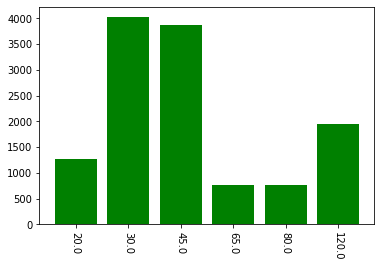

In [380]:


def meanCookTime(time):
    return rating[rating['Cook_Time']==time].Popularity.mean()

cooktimes = []

for time in rating.Cook_Time:
    if time not in cooktimes:
        cooktimes.append(time)
        
tvals = [(float(v.split()[0]),v) for v in cooktimes]
cooktimes = sorted(tvals)

toMean=[j for (i,j) in tvals]

means = []

for time in toMean:
    means.append(meanCookTime(time))

cooktimes = [i for (i,j) in cooktimes]


    
x_pos = [i for i, _ in enumerate(cooktimes)]

plt.bar(x_pos, means, color='green')
plt.xticks(x_pos, cooktimes, rotation = 270)

In [382]:
rating[rating['Cook_Time'] == '120 minutes']

,Restaurant,Latitude,Longitude,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Cook_Time,Popularity
424,ID_607,39.370590,-85.967792,"Bakery, Fast Food",20,50,3.7,101,44,120 minutes,913.5
596,ID_36,39.440505,-85.965610,"Bakery, Fast Food",25,50,2.7,5,3,120 minutes,58.4
785,ID_596,39.046004,-85.285628,"Bakery, Desserts, Fast Food",25,99,3.8,27,23,120 minutes,310
928,ID_4204,39.382805,-85.271197,"Bakery, Fast Food, Desserts",20,50,3.7,147,72,120 minutes,1379.7
1210,ID_8357,39.676069,-85.361422,"Bakery, Desserts",20,99,2.8,4,4,120 minutes,57.6
1947,ID_1342,39.375015,-85.622034,Bakery,15,99,2.8,177,81,120 minutes,1857.6


On a second look, maybe our customers aren't quite as patient as they are wealthy. This shows us that restaurants with 30 and 45 minutes cooktimes are much much more popular than restaurants with higher or lower cooktimes, with a main exception in the 120 minute mark. Since there are only 6 restaurants at the 120 minute mark, we can mostly ignore this due to a small sample size, so the conclusion holds true that restaurants with quicker cooktimes are more popular. 